In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.keras import layers
from datetime import datetime
from tensorflow import keras


2023-12-08 20:54:13.653708: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 20:54:13.655191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 20:54:13.689503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 20:54:13.690123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 20:54:14.355369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Setting hyperparameters

In [2]:
gamma = 0.9 #discount factor
max_steps_for_episode = 10000
eps = np.finfo(np.float32).eps.item()

In [3]:
env = gym.make('CartPole-v1')

### Model definition

In [4]:
num_inputs = 4
num_actions = 2

def get_model():
    inputs = layers.Input(shape=(num_inputs,), name ='Inputs')
    common = layers.Dense(32, activation='swish', name='Common')(inputs)
    action = layers.Dense(64, activation='swish', name='Action1')(common)
    action = layers.Dense(num_actions, activation='softmax', name='OutputAction')(action)

    critic = layers.Dense(64, activation='swish', name='Critic1')(common)
    critic = layers.Dense(128, activation='swish', name='Critic2')(critic)
    critic = layers.Dense(1, activation='linear', name='OutputCritic')(critic)

    return keras.Model(inputs=inputs, outputs=[action, critic])

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Inputs (InputLayer)         [(None, 4)]                  0         []                            
                                                                                                  
 Common (Dense)              (None, 32)                   160       ['Inputs[0][0]']              
                                                                                                  
 Critic1 (Dense)             (None, 64)                   2112      ['Common[0][0]']              
                                                                                                  
 Action1 (Dense)             (None, 64)                   2112      ['Common[0][0]']              
                                                                                              

### Training with this algorithm

In [5]:
optimizer = keras.optimizers.Adam(learning_rate= 3e-3)
loss_function = keras.losses.MeanSquaredError()

action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
running_loss = 0
running_actor_loss = 0
running_critic_loss = 0
episode_count = 0

losses_actor = []
losses_critic = []

start_time = datetime.now()

while True:
    state, _ = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_for_episode):
            #env.render() # for see the animation 
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _, _ = env.step(action)

            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        running_reward = 0.1 * episode_reward + 0.9 * running_reward
        returns = []
        discounted_sum = 0

        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        

        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []

        for log_prob, value, ret in history:
            # Actor
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            # Critic
            critic_losses.append(loss_function(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

        # Log
        running_loss = 0.1 * loss_value + 0.9 * running_loss
        running_critic_loss = 0.1 * sum(critic_losses) + 0.9 * running_critic_loss
        running_actor_loss = 0.1 * sum(actor_losses) + 0.9 * running_actor_loss
        losses_actor.append(sum(actor_losses))
        losses_critic.append(sum(critic_losses))

    episode_count += 1

    if episode_count % 5 == 0:
        template = 'EP: {} - rewards: {:.2f} - loss: {:.3f} -- actor: {:.3f}  - critic: {:.3f}'
        print(template.format(episode_count, running_reward, running_loss, running_actor_loss, running_critic_loss))
    
    if running_reward > 200:
        print("Solved in episode {}!".format(episode_count))
        break

print('Time to train:', datetime.now() - start_time)

EP: 5 - rewards: 15.51 - loss: 15.174 -- actor: -0.440  - critic: 15.615
EP: 10 - rewards: 18.70 - loss: 18.361 -- actor: -1.790  - critic: 20.151
EP: 15 - rewards: 21.21 - loss: 19.433 -- actor: -3.022  - critic: 22.454
EP: 20 - rewards: 28.27 - loss: 25.541 -- actor: -5.670  - critic: 31.211
EP: 25 - rewards: 27.39 - loss: 23.146 -- actor: -5.617  - critic: 28.762
EP: 30 - rewards: 26.34 - loss: 21.981 -- actor: -6.293  - critic: 28.274
EP: 35 - rewards: 24.95 - loss: 21.534 -- actor: -6.441  - critic: 27.975
EP: 40 - rewards: 22.04 - loss: 18.837 -- actor: -4.913  - critic: 23.750
EP: 45 - rewards: 21.55 - loss: 17.527 -- actor: -3.789  - critic: 21.316
EP: 50 - rewards: 22.67 - loss: 16.743 -- actor: -4.881  - critic: 21.624
EP: 55 - rewards: 20.53 - loss: 14.764 -- actor: -4.783  - critic: 19.546
EP: 60 - rewards: 19.52 - loss: 12.486 -- actor: -5.052  - critic: 17.537
EP: 65 - rewards: 19.70 - loss: 11.147 -- actor: -4.862  - critic: 16.010
EP: 70 - rewards: 24.36 - loss: 9.751 -

### Visualization of training data for the actor and the critic

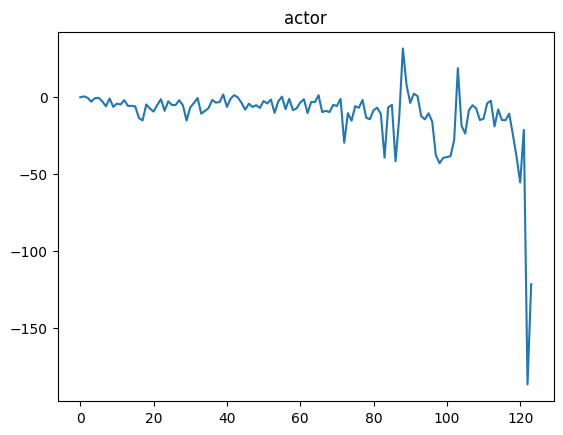

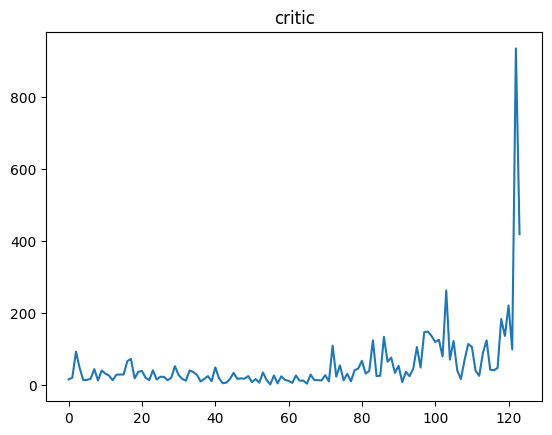

In [6]:
plt.title('actor')
plt.plot(losses_actor)
plt.show()

plt.title('critic')
plt.plot(losses_critic)
plt.show

old_losses_actor = losses_actor
old_losses_critic = losses_critic